# Benefits of using feature selection

In this notebook, we aim at introducing the main benefits that can be
gained when using feature selection.

Indeed, the principal advantage of selecting features within a machine
learning pipeline is to reduce the time to train this pipeline and its time
to predict. We will give an example to highlights these advantages. First, we
generate a synthetic dataset to control the number of features that will be
informative, redundant, repeated, and random.

In [1]:
from sklearn.datasets import make_classification

data, target = make_classification(
    n_samples=5000,
    n_features=100,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=0,
)

We chose to create a dataset with two informative features among a hundred.
To simplify our example, we did not include either redundant or repeated
features.

We will create two machine learning pipelines. The former will be a random
forest that will use all available features. The latter will also be a random
forest, but we will add a feature selection step to train this classifier.
The feature selection is based on a univariate test (ANOVA F-value) between
each feature and the target that we want to predict. The features with the
two most significant scores are selected.

Let's create the model without any feature selection

In [2]:
from sklearn.ensemble import RandomForestClassifier

model_without_selection = RandomForestClassifier(n_jobs=2)

Then, let's create a pipeline where the first stage will make the feature
selection processing.

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline


model_with_selection = make_pipeline(
    SelectKBest(score_func=f_classif, k=2),
    RandomForestClassifier(n_jobs=2),
)

We will measure the average time spent to train each pipeline and make it
predict. Besides, we will compute the testing score of the model. We
will collect these results via cross-validation.

Let's start with the random forest without feature selection. We will store
the results into a dataframe.

In [4]:
import pandas as pd
from sklearn.model_selection import cross_validate

cv_results_without_selection = cross_validate(model_without_selection, data,
                                              target)
cv_results_without_selection = pd.DataFrame(cv_results_without_selection)

Now, we will repeat the process for the pipeline incorporating the feature
selection.

In [5]:
cv_results_with_selection = cross_validate(
    model_with_selection, data, target, return_estimator=True)
cv_results_with_selection = pd.DataFrame(cv_results_with_selection)

To analyze the results, we will merge the results from the two pipeline in
a single pandas dataframe.

In [6]:
cv_results = pd.concat(
    [cv_results_without_selection, cv_results_with_selection],
    axis=1,
    keys=["Without feature selection", "With feature selection"],
)
# swap the level of the multi-index of the columns
cv_results = cv_results.swaplevel(axis="columns")

Let's first analyze the train and score time for each pipeline.

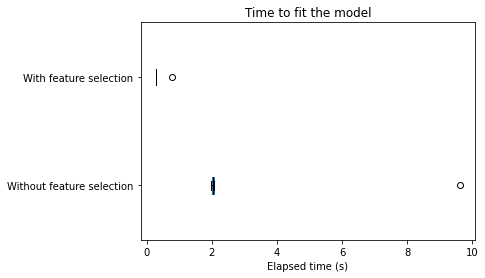

In [7]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
cv_results["fit_time"].plot.box(color=color, vert=False)
plt.xlabel("Elapsed time (s)")
_ = plt.title("Time to fit the model")

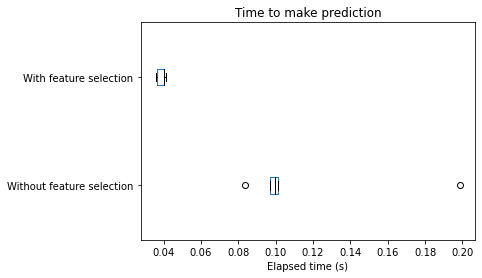

In [8]:
cv_results["score_time"].plot.box(color=color, vert=False)
plt.xlabel("Elapsed time (s)")
_ = plt.title("Time to make prediction")

We can draw the same conclusions for both training and scoring elapsed time:
selecting the most informative features speed-up our pipeline.

Of course, such speed-up is beneficial only if the statistical performance in
terms of metrics remain the same. Let's check the testing score.

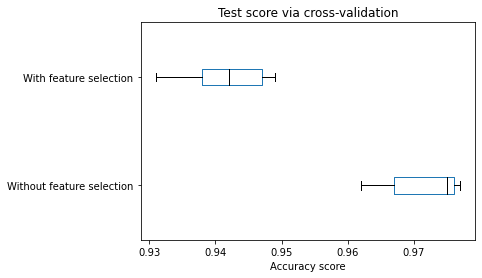

In [9]:
cv_results["test_score"].plot.box(color=color, vert=False)
plt.xlabel("Accuracy score")
_ = plt.title("Test score via cross-validation")

We can observe that the model's statistical performance selecting a subset of
features decreases compared with the model using all available features.
Since we generated the dataset, we can infer that the decrease is because of
the selection. The feature selection algorithm did not choose the two
informative features.

We can investigate which feature have been selected during the
cross-validation. We will print the indices of the two selected features.

In [10]:
import numpy as np

for idx, pipeline in enumerate(cv_results_with_selection["estimator"]):
    print(
        f"Fold #{idx} - features selected are: "
        f"{np.argsort(pipeline[0].scores_)[-2:]}"
    )

Fold #0 - features selected are: [89 53]
Fold #1 - features selected are: [29 53]
Fold #2 - features selected are: [52 53]
Fold #3 - features selected are: [49 53]
Fold #4 - features selected are: [49 53]


We see that the feature `53` is always selected while the other feature
varies depending on the cross-validation fold.

If we would like to keep our score with similar statistical performance, we
could choose another metric to perform the test or select more features. For
instance, we could select the number of features based on a specific
percentile of the highest scores. Besides, we should keep in mind that we
simplify our problem by having informative and not informative features.
Correlation between features makes the problem of feature selection even
harder.

Therefore, we could come with a much more complicated procedure that could
tune (via cross-validation) the number of selected features and change
the way feature is selected (e.g. using a machine-learning model). However,
going towards these solutions alienates the feature selection's primary
purpose to get a significant train/test speed-up. Also, if the primary goal
was to get a more performant model, performant models exclude non-informative
features natively.